In [11]:
import requests, time, itertools, math, shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np

from court import court_shapes

pd.set_option('display.max_columns',50)
import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from shot_chart_viz import *

In [2]:
#df = pd.read_csv('data/final_df.csv',index_col=0)

## SHOT CHARTS + DROPDOWNS

In [21]:
player_dropdown = widgets.Dropdown(
    options = sorted(list(set(df.name))),
    value='James Harden',
    description='Player:',
    disabled=False)

grid_slider = widgets.IntSlider(
    value=25,
    min=5, max=60,
    step=5,
    description='Bubble Size:',
    disabled=False)

interact(freq_shooting_plot, player_name=player_dropdown, gridNum=grid_slider);

interactive(children=(Dropdown(description='Player:', index=200, options=('AJ Price', 'Aaron Brooks', 'Aaron G…

In [14]:
team_dropdown = widgets.Dropdown(
    options = sorted(list(set(df.team_name))),
    value='New York Knicks',
    description='Team:',
    disabled=False)

grid_slider_team = widgets.IntSlider(
    value=30,
    min=5, max=80,
    step=5,
    description='Bubble Size:',
    disabled=False)

interact(team_freq_plot, team=team_dropdown, gridNum=grid_slider_team);

interactive(children=(Dropdown(description='Team:', index=19, options=('Atlanta Hawks', 'Boston Celtics', 'Bro…

## HEXBIN CHARTS

In [12]:
def find_shootingPcts(shot_df, gridNum):
    x2 = shot_df.x[(shot_df['y']<425.1) & (shot_df.shot_type==2)]
    y2 = shot_df.y[(shot_df['y']<425.1) & (shot_df.shot_type==2)]

    x2_made = shot_df.x[(shot_df['shot_made_flag']==1) & (shot_df['y']<425.1) & (shot_df.shot_type==2)]
    y2_made = shot_df.y[(shot_df['shot_made_flag']==1) & (shot_df['y']<425.1) & (shot_df.shot_type==2)]

    #compute number of shots made and taken from each hexbin location
    hb_shot2 = plt.hexbin(x2, y2, gridsize=gridNum, extent=(-250,250,425,-50));
    plt.close()
    hb_made2 = plt.hexbin(x2_made, y2_made, gridsize=gridNum, extent=(-250,250,425,-50),cmap=plt.cm.Reds);
    plt.close()

    #compute shooting percentage
    ShootingPctLocs2 = hb_made2.get_array() / hb_shot2.get_array()
    ShootingPctLocs2[np.isnan(ShootingPctLocs2)] = 0 #makes 0/0s=0
    
    #############################################################################################################
    #############################################################################################################
    ###########################################  THREE POINTERS  ################################################
    #############################################################################################################
    #############################################################################################################
    
    x3 = shot_df.x[(shot_df['y']<425.1) & (shot_df.shot_type==3)]
    y3 = shot_df.y[(shot_df['y']<425.1) & (shot_df.shot_type==3)]

    x3_made = shot_df.x[(shot_df['shot_made_flag']==1) & (shot_df['y']<425.1) & (shot_df.shot_type==3)]
    y3_made = shot_df.y[(shot_df['shot_made_flag']==1) & (shot_df['y']<425.1) & (shot_df.shot_type==3)]

    #compute number of shots made and taken from each hexbin location
    hb_shot3 = plt.hexbin(x3, y3, gridsize=gridNum, extent=(-250,250,425,-50));
    plt.close()
    hb_made3 = plt.hexbin(x3_made, y3_made, gridsize=gridNum, extent=(-250,250,425,-50),cmap=plt.cm.Reds);
    plt.close()

    #compute shooting percentage
    ShootingPctLocs3 = hb_made3.get_array() / hb_shot3.get_array()
    ShootingPctLocs3[np.isnan(ShootingPctLocs3)] = 0 #makes 0/0s=0
    
    return (ShootingPctLocs2, hb_shot2, ShootingPctLocs3, hb_shot3)

In [19]:
def freq_shooting_plot(player_name,gridNum=35, twos=True, threes=True):
    plot_size=(10,8)
    shot_df = df[df.name==player_name]

    from matplotlib.patches import Circle
    #compute shooting percentage and # of shots
    (ShootingPctLocs2, shotNumber2) = find_shootingPcts(shot_df, gridNum)[0:2]
    (ShootingPctLocs3, shotNumber3) = find_shootingPcts(shot_df, gridNum)[2:]

    #draw figure and court
    fig = plt.figure(figsize=plot_size)#(12,7)
    ax = plt.axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court(outer_lines=False)
    plt.xlim(-250,250)
    plt.ylim(400, -25)

    #draw player image
    zoom = np.float(plot_size[0])/(12.0*2) #how much to zoom the player's pic. I have this hackily dependent on figure size
    img = acquire_playerPic(shot_df.player_id, zoom)
    ax.add_artist(img)
    
    #############################################################################################################
    #############################################################################################################
    ############################################  TWO POINTERS  #################################################
    #############################################################################################################
    #############################################################################################################
    if twos==True:
        cmap = mymap.from_list('Color Map',[(0,'#ff0000'),(.45,'#ffff00'),(.6,'#00ff00'), (1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs2):
            restricted2 = Circle(shotNumber2.get_offsets()[i], radius=shotNumber2.get_array()[i],
                                color=cmap(shots),alpha=1, fill=True)
            if restricted2.radius > 240/gridNum: restricted2.radius=240/gridNum
            ax.add_patch(restricted2)

        #draw color bar
        ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
        cb = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap, orientation='vertical')
        cb.set_label('Field Goal %', labelpad=20)
        cb.set_ticks([0.0, 0.25, .485, 0.75, 1.0])
        cb.set_ticklabels(['0%','25%','48.5%\nLg Avg', '75%', '100%'])
    
    #############################################################################################################
    #############################################################################################################
    ###########################################  THREE POINTERS  ################################################
    #############################################################################################################
    #############################################################################################################
    if threes==True:
        #plotting 3 pointers separately to account for expected lower fg% from deep
        cmap3 = mymap.from_list('Color Map',[(0,'#ff0000'),(.35,'#ffff00'),(.6,'#00ff00'),(1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs3):
            restricted3 = Circle(shotNumber3.get_offsets()[i], radius=shotNumber3.get_array()[i],
                                color=cmap3(shots),alpha=1, fill=True)
            if restricted3.radius > 240/gridNum: restricted3.radius=240/gridNum
            ax.add_patch(restricted3)

        #draw color bar
        ax3 = fig.add_axes([1.1, 0.1, 0.02, 0.8])
        cb3 = matplotlib.colorbar.ColorbarBase(ax3,cmap=cmap3, orientation='vertical')
        cb3.set_label('Three Point %',labelpad=-8)
        cb3.set_ticks([0.0, 0.25,.35, 0.5, 0.75, 1.0])
        cb3.set_ticklabels(['0%','25%','35% - Lg Avg', '50%','75%', '100%'])

    ax.set_title(shot_df.name.unique()[0] +' - Shot Chart 2014-15')
    #plot season stats
    ax.text(135,395,get_season_stats(player_name)[1])
    
    plt.show()
    return ax

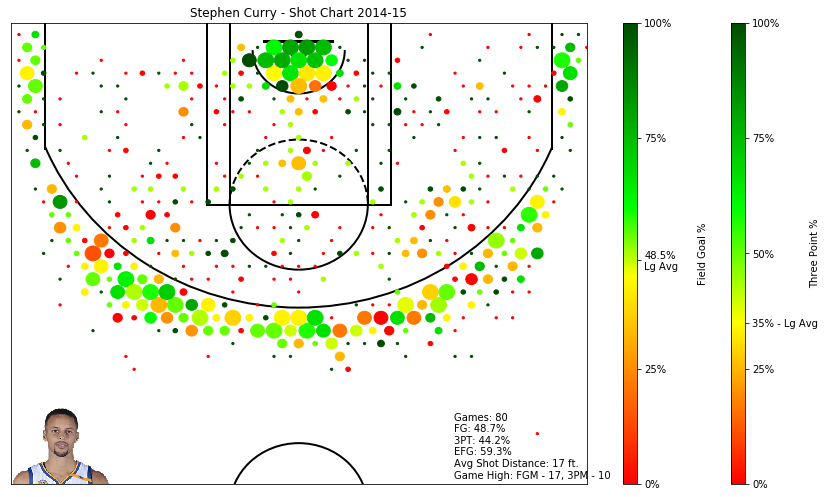

In [20]:
#mymap=mymap.from_list('Color Map',[(0,'#cc0000'),(.4,'#e6e600'),(1,'#004d00')])
freq_shooting_plot("Stephen Curry");

# ADDITIONAL SHOT CHART IDEAS

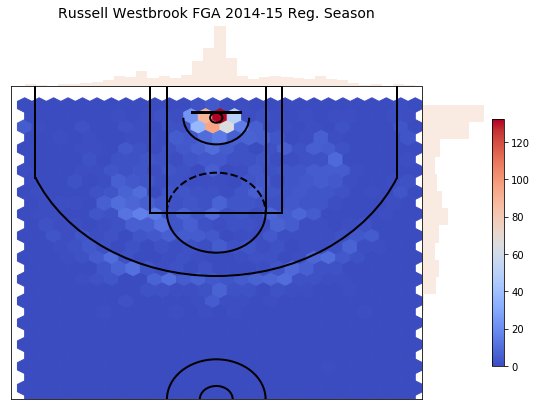

In [44]:
rw = df[df.name=='Russell Westbrook']
# create our jointplot

cmap=plt.cm.coolwarm
joint_shot_chart = sns.jointplot(rw.x, rw.y, stat_func=None,
                                 kind='hex', space=0, cmap=cmap, color=cmap(.6))

joint_shot_chart.fig.set_size_inches(8,6)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto 
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title(rw.name.unique()[0] + ' FGA 2014-15 Reg. Season', y=1.2, fontsize=14)

plt.colorbar()
plt.show()

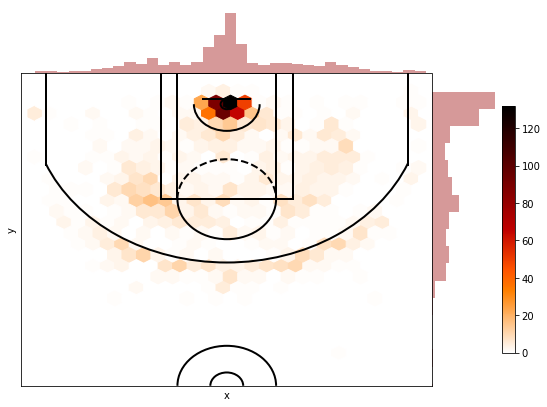

In [31]:
cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(rw.x, rw.y, stat_func=None,
                                 kind='hex', space=0, color=cmap(.6), cmap=cmap)

joint_shot_chart.fig.set_size_inches(8,6)
ax = joint_shot_chart.ax_joint
draw_court(ax)
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
plt.colorbar();

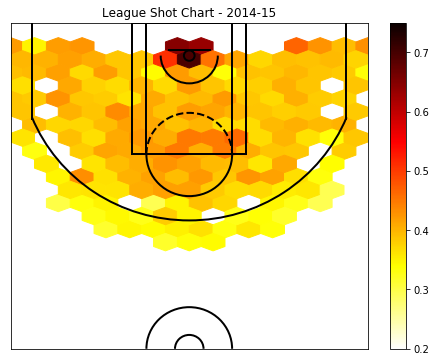

In [87]:
plt.figure(figsize=(8,6))
plt.hexbin(df.x,df.y,gridsize=(15,24),C=df.shot_made_flag,
           bins=None, cmap=plt.cm.hot_r, mincnt=200,
           vmin=0.2,vmax=.75)
ax=draw_court()
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
plt.title('League Shot Chart - 2014-15')
#ax.text(-250,445,'Note: Colors Represent FG% Relative to League Average')
plt.colorbar();

In [37]:
sc = df[df.name=='Stephen Curry']

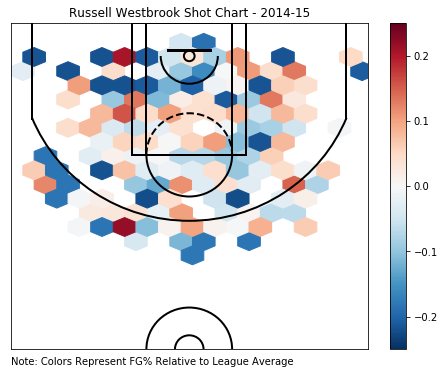

In [158]:
plt.figure(figsize=(8,6))
plt.hexbin(rw.x,rw.y,gridsize=(15,12),C=rw.shot_made_flag-rw.lg_avg,
           bins='log',
           cmap=plt.cm.RdBu_r, mincnt=1,
           vmin=-.25,vmax=.25)
ax2=draw_court()
ax2.set_xlim(-250,250)
ax2.set_ylim(422.5, -47.5)
plt.title(rw.name.unique()[0] + ' Shot Chart - 2014-15')
ax2.text(-250,445,'Note: Colors Represent FG% Relative to League Average')
plt.colorbar();

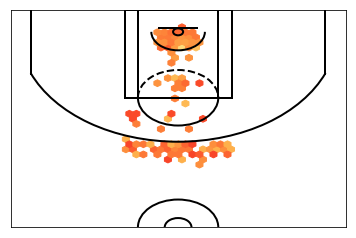

In [131]:
plt.hexbin(sc.x[sc.shot_area=='C'],sc.y[sc.shot_area=='C'], gridsize=(15,24),
           C=sc.shot_made_flag[sc.shot_area=='C']-sc.lg_avg[sc.shot_area=='C'], bins='log',
           cmap=plt.cm.YlOrRd, mincnt=1, vmin=-.75,vmax=.75)
ax3=draw_court()
ax3.set_xlim(-250,250)
ax3.set_ylim(422.5,-47.5);

In [83]:
gsw = df[df.team_name=='Golden State Warriors'].reset_index(drop=True)

In [84]:
gsw_tab = pd.crosstab(gsw.name, columns=[gsw.shot_made_flag, gsw.shot_zone, gsw.shot_area],
                      margins=True, margins_name='FGA')

In [85]:
fgm_arr = []
for player in gsw_tab.index:
    fgm_arr.append(len(gsw[(gsw.name==player)&(gsw.shot_made_flag==1)]))

In [86]:
gsw_tab['FGM'] = fgm_arr
gsw_tab['FG_PCT'] = round(gsw_tab.FGM/gsw_tab.FGA,3)
gsw_tab

shot_made_flag                   0                                       \
shot_zone            Above Break 3           Corner 3      Heave          
shot_area                        C    L    R        L    R     C   L  R   
name                                                                      
Andre Iguodala                  17   26   33       27   29     4   0  2   
Andrew Bogut                     0    0    0        0    0     0   0  0   
Brandon Rush                     4    9    5        5    1     0   0  0   
David Lee                        1    0    0        0    0     0   0  1   
Draymond Green                  74   80   43       17    4     0   0  0   
Festus Ezeli                     0    0    0        0    0     0   0  0   
Harrison Barnes                  9   33   24       39   22     0   1  0   
James Michael McAdoo             0    0    0        0    0     0   0  0   
Justin Holiday                   4   25   28        7    9     1   0  0   
Klay Thompson                   45   79  111       29   35     0   2  2   
Leandro Barbosa                 11   22   17        8    9     0   2  0   
Marreese Speights                2    1    3        2    1     1   0  3   
Ognjen Kuzmic                    0    0    0        0    0     0   0  0   
Shaun Livingston                 0    0    1        0    0     1   0  0   
Stephen Curry                   95   98  122       14   21     2   6  1   
FGA                            262  373  387      148  131     9  11  9   

shot_made_flag                                                            \
shot_zone            Mid Range           Paint           Restricted Area   
shot_area                    C    L    R     C    L    R               C   
name                                                                       
Andre Iguodala              10   27   18    18    7    9              38   
Andrew Bogut                 2    4    9    42    8   14              76   
Brandon Rush                 1    6    2     2    0    1               7   
David Lee                    7   14   15    35   12    7              61   
Draymond Green              11   18   23    34   11   13              98   
Festus Ezeli                 1    6    4    11    6    6              29   
Harrison Barnes             13   30   45    23   13   15              73   
James Michael McAdoo         0    1    1     1    1    2              14   
Justin Holiday               9    8   15     9    3    2              24   
Klay Thompson               43   63   92    63   17   26              90   
Leandro Barbosa              8   20   16    23    5    5              57   
Marreese Speights           61   48   72    27    3   19              85   
Ognjen Kuzmic                0    1    0     1    0    0               2   
Shaun Livingston             5   43   28    34   26   21              39   
Stephen Curry               31   70   66    41    7   18              95   
FGA                        202  359  406   364  119  158             788   

shot_made_flag                   1                                          \
shot_zone            Above Break 3           Corner 3      Heave Mid Range   
shot_area                        C    L    R        L    R     R         C   
name                                                                         
Andre Iguodala                   9   20   19       15   11     0         7   
Andrew Bogut                     0    0    0        0    0     0         0   
Brandon Rush                     0    1    1        1    0     0         0   
David Lee                        0    0    0        0    0     0         4   
Draymond Green                  47   38   18        3    5     0         6   
Festus Ezeli                     0    0    0        0    0     0         0   
Harrison Barnes                  4   16   13       23   31     0        12   
James Michael McAdoo             0    0    0        0    0     0         0   
Justin Holiday                   5   10   

In [90]:
# #gsw_arr = np.zeros((15,len(gsw_tab.columns[:-3])/2))
# for index, col in enumerate(gsw_tab.columns[:-3]):
#     if col[1]!='Heave':
#         print(round(gsw_tab[0][col[1]][col[2]]/gsw_tab[1][col[1]][col[2]],3))

In [89]:
gsw_tab

shot_made_flag                   0                                       \
shot_zone            Above Break 3           Corner 3      Heave          
shot_area                        C    L    R        L    R     C   L  R   
name                                                                      
Andre Iguodala                  17   26   33       27   29     4   0  2   
Andrew Bogut                     0    0    0        0    0     0   0  0   
Brandon Rush                     4    9    5        5    1     0   0  0   
David Lee                        1    0    0        0    0     0   0  1   
Draymond Green                  74   80   43       17    4     0   0  0   
Festus Ezeli                     0    0    0        0    0     0   0  0   
Harrison Barnes                  9   33   24       39   22     0   1  0   
James Michael McAdoo             0    0    0        0    0     0   0  0   
Justin Holiday                   4   25   28        7    9     1   0  0   
Klay Thompson                   45   79  111       29   35     0   2  2   
Leandro Barbosa                 11   22   17        8    9     0   2  0   
Marreese Speights                2    1    3        2    1     1   0  3   
Ognjen Kuzmic                    0    0    0        0    0     0   0  0   
Shaun Livingston                 0    0    1        0    0     1   0  0   
Stephen Curry                   95   98  122       14   21     2   6  1   
FGA                            262  373  387      148  131     9  11  9   

shot_made_flag                                                            \
shot_zone            Mid Range           Paint           Restricted Area   
shot_area                    C    L    R     C    L    R               C   
name                                                                       
Andre Iguodala              10   27   18    18    7    9              38   
Andrew Bogut                 2    4    9    42    8   14              76   
Brandon Rush                 1    6    2     2    0    1               7   
David Lee                    7   14   15    35   12    7              61   
Draymond Green              11   18   23    34   11   13              98   
Festus Ezeli                 1    6    4    11    6    6              29   
Harrison Barnes             13   30   45    23   13   15              73   
James Michael McAdoo         0    1    1     1    1    2              14   
Justin Holiday               9    8   15     9    3    2              24   
Klay Thompson               43   63   92    63   17   26              90   
Leandro Barbosa              8   20   16    23    5    5              57   
Marreese Speights           61   48   72    27    3   19              85   
Ognjen Kuzmic                0    1    0     1    0    0               2   
Shaun Livingston             5   43   28    34   26   21              39   
Stephen Curry               31   70   66    41    7   18              95   
FGA                        202  359  406   364  119  158             788   

shot_made_flag                   1                                          \
shot_zone            Above Break 3           Corner 3      Heave Mid Range   
shot_area                        C    L    R        L    R     R         C   
name                                                                         
Andre Iguodala                   9   20   19       15   11     0         7   
Andrew Bogut                     0    0    0        0    0     0         0   
Brandon Rush                     0    1    1        1    0     0         0   
David Lee                        0    0    0        0    0     0         4   
Draymond Green                  47   38   18        3    5     0         6   
Festus Ezeli                     0    0    0        0    0     0         0   
Harrison Barnes                  4   16   13       23   31     0        12   
James Michael McAdoo             0    0    0        0    0     0         0   
Justin Holiday                   5   10   